In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score

from tensorflow.keras.datasets import mnist, fashion_mnist

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, losses
import tensorflow as tf

Matplotlib is building the font cache; this may take a moment.


#### Datasets

In [2]:
(normal_x_train, _), (normal_x_test, _) = mnist.load_data()

In [3]:
normal_x_train = normal_x_train.reshape((len(normal_x_train), np.prod(normal_x_train.shape[1:])))
normal_x_test = normal_x_test.reshape((len(normal_x_test), np.prod(normal_x_test.shape[1:])))

normal_x_train = normal_x_train.astype('float32') / 255.0
normal_x_test = normal_x_test.astype('float32') / 255.0

normal_y_test = np.full((10000,), 1)


print(normal_x_train.shape)
print(normal_x_test.shape)
print(normal_y_test.shape)

(60000, 784)
(10000, 784)
(10000,)


In [4]:
(anomalous_x_train, _), (anomalous_x_test, _) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [5]:
anomalous_x_train = anomalous_x_train.reshape((len(anomalous_x_train), np.prod(anomalous_x_train.shape[1:])))
anomalous_x_test = anomalous_x_test.reshape((len(anomalous_x_test), np.prod(anomalous_x_test.shape[1:])))

anomalous_x_train = anomalous_x_train.astype('float32') / 255.0
anomalous_x_test = anomalous_x_test.astype('float32') / 255.0

anomalous_y_test = np.full((10000,), 0)

print(anomalous_x_train.shape)
print(anomalous_x_test.shape)
print(anomalous_y_test.shape)

(60000, 784)
(10000, 784)
(10000,)


#### Autoencoder

In [6]:
latent_dim = 128 

class AnomalyDetector(models.Model):
  def __init__(self, latent_dim):
    super(AnomalyDetector, self).__init__()
    
    self.latent_dim = latent_dim   
    
    self.encoder = tf.keras.Sequential([
      tf.keras.Input(784),
      layers.Dense(latent_dim, activation='relu'),
    ])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector(latent_dim)

In [7]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

### Train

In [8]:
history = autoencoder.fit(
  normal_x_train, 
  normal_x_train, 
  epochs=10, 
  shuffle=True,
  validation_data=(normal_x_test, normal_x_test)
)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0175 - val_loss: 0.0054
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.001

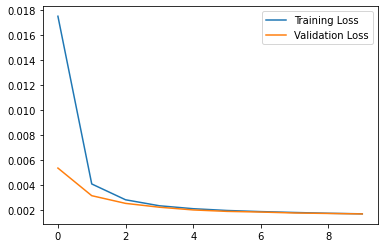

In [9]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

### Test

In [10]:
encoded_imgs = autoencoder.encoder(normal_x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

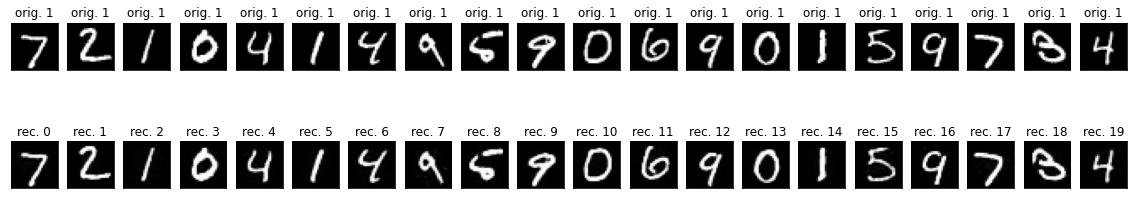

In [11]:
n = 20
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(normal_x_test[i].reshape(28, 28))
    plt.title(f'orig. {1}')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.title(f'rec. {i}')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Anomaly detection

In [12]:
reconstructions = autoencoder.predict(normal_x_train)
train_loss = tf.keras.losses.MSE(reconstructions, normal_x_train)

threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.0025949571


In [13]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.MSE(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [14]:
def shuffle_in_unison(a, b):
  indices = np.arange(a.shape[0])
  np.random.shuffle(indices)

  return (a[indices], b[indices])

In [15]:
x_test = np.concatenate((normal_x_test, anomalous_x_test))
y_test = np.concatenate((normal_y_test, anomalous_y_test))

x_test, y_test = shuffle_in_unison(x_test, y_test)

preds = predict(autoencoder, x_test, threshold)

print_stats(preds, y_test)

Accuracy = 0.93075
Precision = 1.0
Recall = 0.8615
